In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [2]:
df = pd.read_csv('recipes_w_search_terms.csv')

In [3]:
# Preprocess list values
df["ingredients"] = df["ingredients"].apply(literal_eval)
df["steps"] = df["steps"].apply(literal_eval)
df["tags"] = df["tags"].apply(literal_eval)
df["search_terms"] = df["search_terms"].apply(literal_eval)

In [ ]:
def categorize_mealtimes(terms):
    for meal in ['breakfast', 'lunch', 'dinner', 'dessert', "side"]:
        if meal in terms: return meal
    return 'other'

In [47]:
df["meal"] = df["search_terms"].apply(categorize_mealtimes)
df["meal"] = pd.Categorical(df["meal"])

In [4]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [5]:
ingredients = df["ingredients"].apply('\t'.join).apply(lambda x: x.replace(" ", "_"))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()

vec.fit(ingredients)
X = vec.transform(ingredients)


CountVectorizer()

In [51]:
from sklearn.model_selection import train_test_split

y = df["meal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [52]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

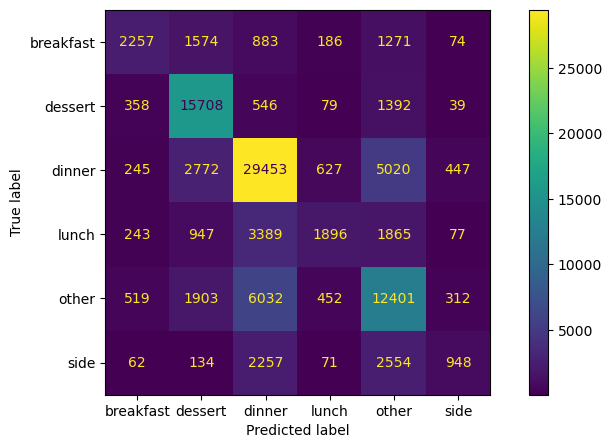

In [53]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

top 5 keywords per class:
       breakfast          dessert                             dinner  \
0           eggs            sugar                        ground_beef   
1           milk          vanilla  boneless_skinless_chicken_breasts   
2            egg            flour                              onion   
3  baking_powder  vanilla_extract                             butter   
4       cinnamon      brown_sugar                      garlic_cloves   

             lunch          other       side  
0              all          water     butter  
1       mayonnaise  purpose_flour       salt  
2            bread  baking_powder  olive_oil  
3  flour_tortillas  chicken_broth   potatoes  
4   hamburger_buns         celery     pepper  


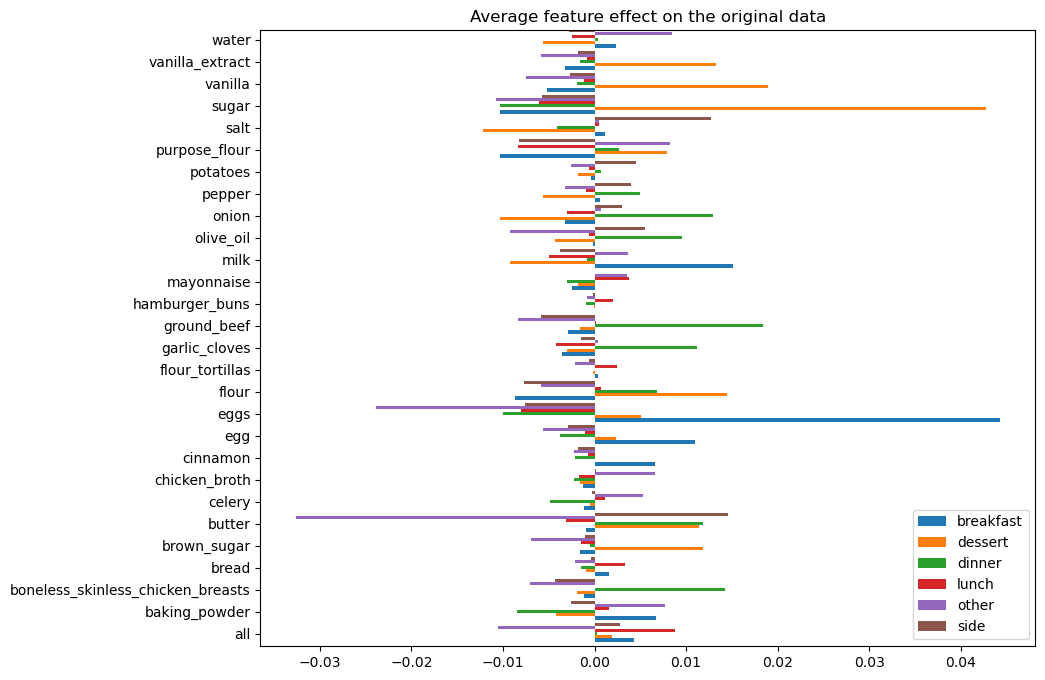

In [60]:
import numpy as np
import pandas as pd

meal_names = ['breakfast', 'dessert', 'dinner', 'lunch', "other", "side"]
feature_names = vec.get_feature_names_out()

def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(meal_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(meal_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")